## Introduction

## Exploratory Analysis

In [1]:
library(readr)
library(dplyr)
library(glmnet)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: Matrix

Loading required package: foreach

Loaded glmnet 2.0-16




There are 2 csv files in the current version of the dataset:


In [2]:
train_main <- read_csv("/kaggle/input/train.csv")
test <- read_csv("/kaggle/input/test.csv")

train_main_labels <- train_main$Activity
test_labels <- test$Activity
cat(paste0("Data loaded successfully. Training set has ", nrow(train_main), " rows and ", ncol(train_main), " columns."))


Warning message:
“Duplicated column names deduplicated: 'fBodyAcc-bandsEnergy()-1,8' => 'fBodyAcc-bandsEnergy()-1,8_1' [317], 'fBodyAcc-bandsEnergy()-9,16' => 'fBodyAcc-bandsEnergy()-9,16_1' [318], 'fBodyAcc-bandsEnergy()-17,24' => 'fBodyAcc-bandsEnergy()-17,24_1' [319], 'fBodyAcc-bandsEnergy()-25,32' => 'fBodyAcc-bandsEnergy()-25,32_1' [320], 'fBodyAcc-bandsEnergy()-33,40' => 'fBodyAcc-bandsEnergy()-33,40_1' [321], 'fBodyAcc-bandsEnergy()-41,48' => 'fBodyAcc-bandsEnergy()-41,48_1' [322], 'fBodyAcc-bandsEnergy()-49,56' => 'fBodyAcc-bandsEnergy()-49,56_1' [323], 'fBodyAcc-bandsEnergy()-57,64' => 'fBodyAcc-bandsEnergy()-57,64_1' [324], 'fBodyAcc-bandsEnergy()-1,16' => 'fBodyAcc-bandsEnergy()-1,16_1' [325], 'fBodyAcc-bandsEnergy()-17,32' => 'fBodyAcc-bandsEnergy()-17,32_1' [326], 'fBodyAcc-bandsEnergy()-33,48' => 'fBodyAcc-bandsEnergy()-33,48_1' [327], 'fBodyAcc-bandsEnergy()-49,64' => 'fBodyAcc-bandsEnergy()-49,64_1' [328], 'fBodyAcc-bandsEnergy()-1,24' => 'fBodyAcc-bandsEnergy()-1,24_1'

Data loaded successfully. Training set has 7352 rows and 563 columns.

In [3]:
# Fix duplicate colnames

names(train_main) <- make.names(names(train_main), unique = TRUE)
names(test) <- names(train_main)

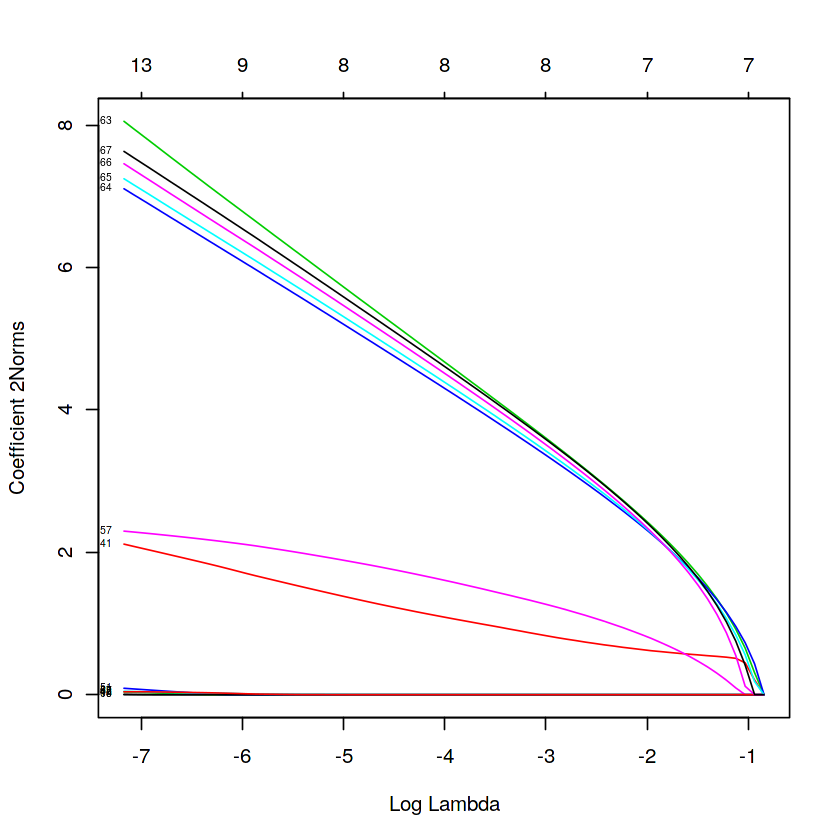

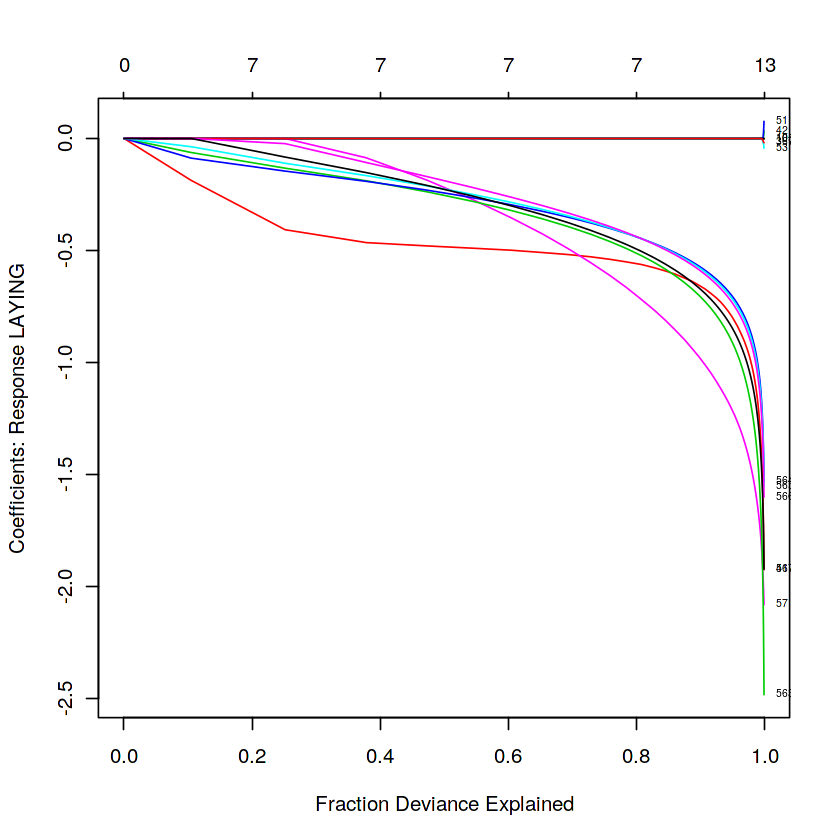

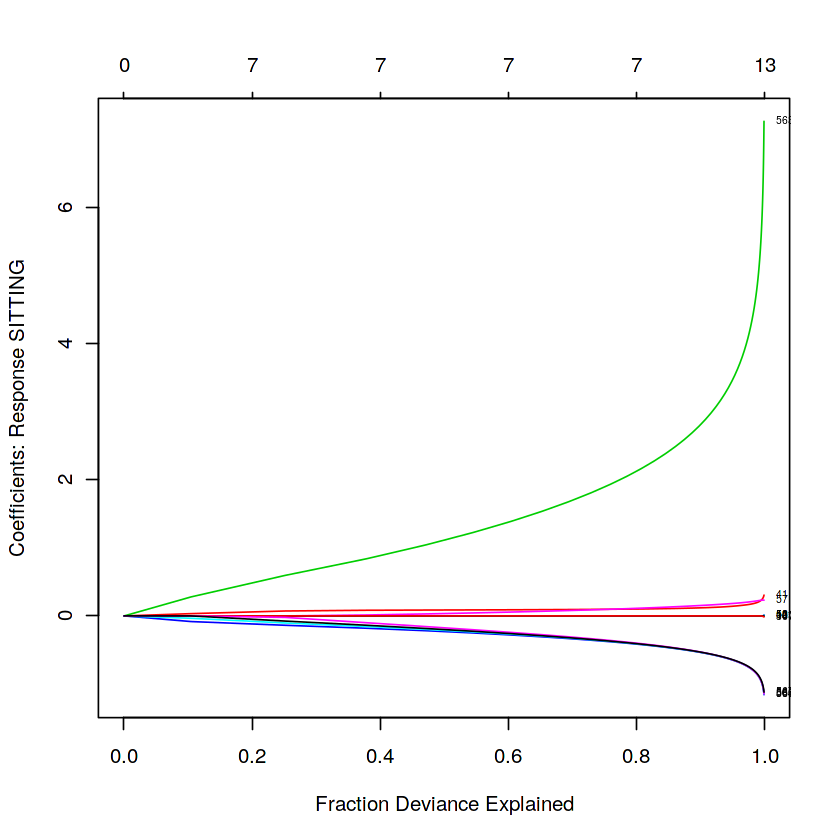

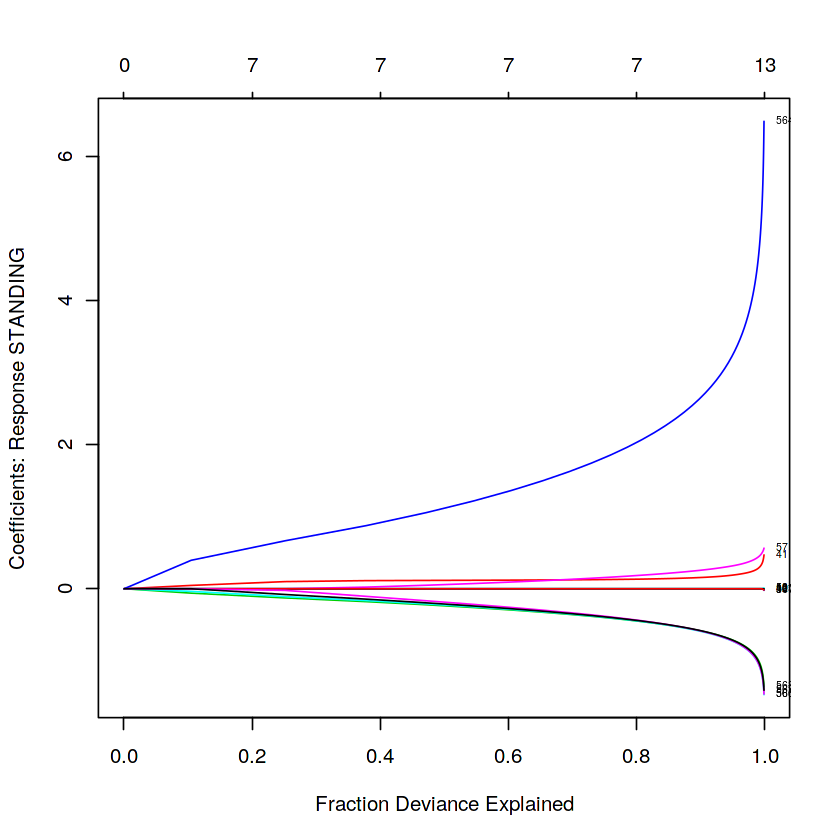

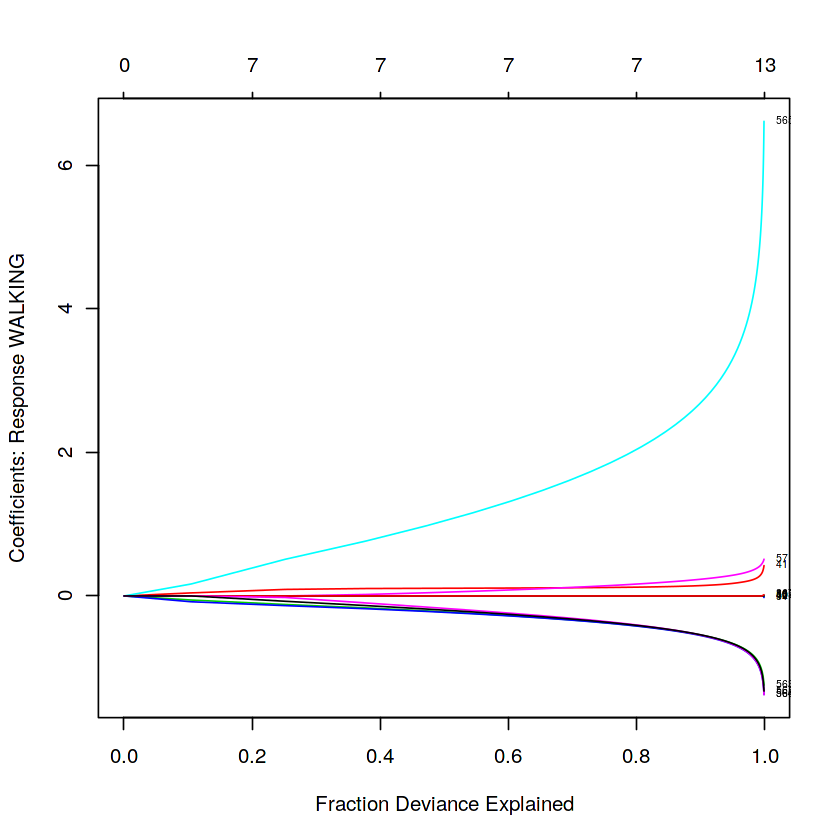

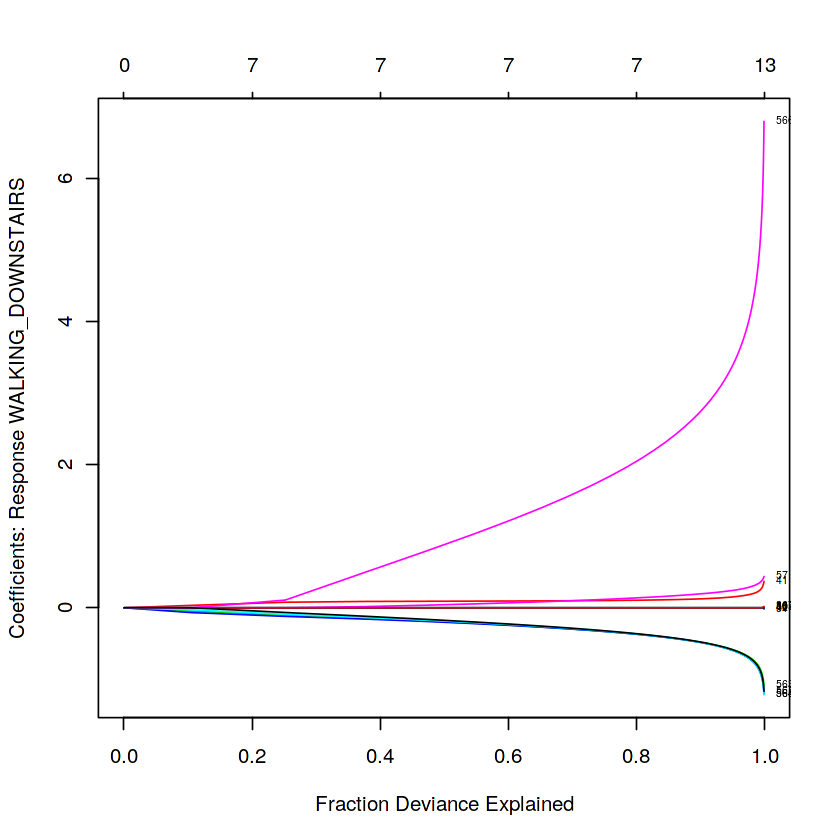

Loading required package: doMC

Loading required package: iterators

Loading required package: parallel



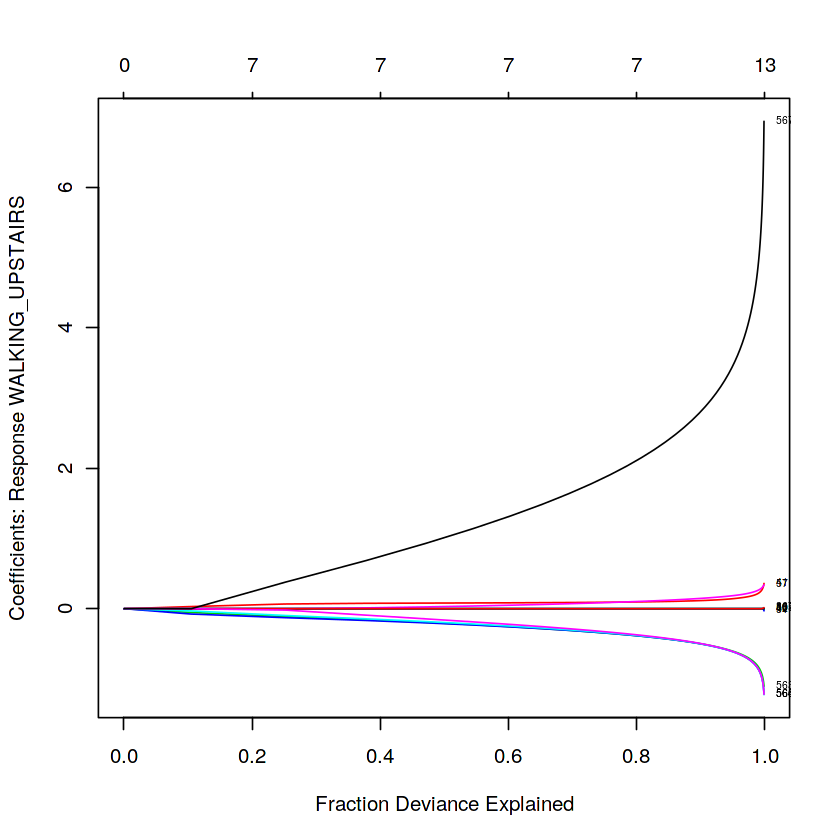

[1] 0.3254287
[1] 0.3254287


[1] 0.0013446756 0.0012252183 0.0011163733 0.0010171978 0.0009268327
[6] 0.0008444955

                    cal_labels
cal.pred             LAYING SITTING STANDING WALKING WALKING_DOWNSTAIRS
  LAYING                313       0        0       0                  0
  SITTING                 0     256        0       0                  0
  STANDING                0       0      261       0                  0
  WALKING                 0       0        0     254                  0
  WALKING_DOWNSTAIRS      0       0        0       0                215
  WALKING_UPSTAIRS        0       0        0       0                  0
                    cal_labels
cal.pred             WALKING_UPSTAIRS
  LAYING                            0
  SITTING                           0
  STANDING                          0
  WALKING                           0
  WALKING_DOWNSTAIRS                0
  WALKING_UPSTAIRS                193

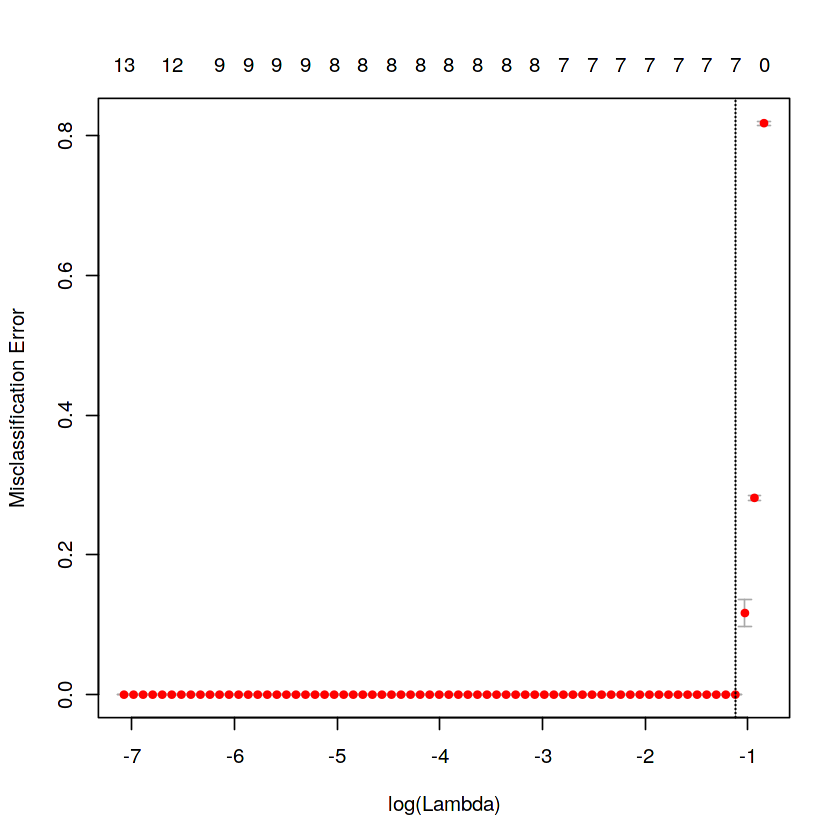

In [4]:
set.seed(42)
idx = sample(c(TRUE, FALSE), nrow(train_main), replace = TRUE, prob = c(0.8, 0.2))
 
train = subset(train_main, idx)
train_labels  = subset(train_main_labels, idx)
cal = subset(train_main, !idx)
cal_labels = subset(train_main_labels, !idx)
x <- model.matrix(train_labels ~ ., train)[,-1]
fit = glmnet(x, train_labels, family = "multinomial", type.multinomial = "grouped")
plot(fit, xvar = "lambda", label = TRUE, type.coef = "2norm")
plot(fit, xvar = "dev", label = TRUE)
require(doMC)
registerDoMC(cores=4)
cvfit=cv.glmnet(x, train_labels, family="multinomial", type.measure="class", type.multinomial = "grouped", nfolds = 5, parallel = TRUE)
plot(cvfit)
print(cvfit$lambda.1se)
print(cvfit$lambda.min)
bestlam = cvfit$lambda.1se
tail(cvfit$lambda)
nx = model.matrix(cal_labels ~., cal)[,-1]
cal.pred <- predict(cvfit, s = bestlam, newx = nx, type = "class")
table(cal.pred, cal_labels)
acc = sum(cal.pred == cal_labels) / length(cal.pred)

In [5]:
# Accuracy

cat(paste0("Our accuracy against our calibration dataset is: ", acc))
testx = model.matrix(test_labels ~., test)[,-1]
head(testx)
test.pred <- predict(cvfit, s = bestlam, newx = testx, type = "class")
acc = sum(test.pred == test_labels) / length(test.pred)
cat(paste0("Our accuracy against our test dataset is: ", acc))

Our accuracy against our calibration dataset is: 1

,tBodyAcc.mean...X,tBodyAcc.mean...Y,tBodyAcc.mean...Z,tBodyAcc.std...X,tBodyAcc.std...Y,tBodyAcc.std...Z,tBodyAcc.mad...X,tBodyAcc.mad...Y,tBodyAcc.mad...Z,tBodyAcc.max...X,⋯,angle.tBodyGyroJerkMean.gravityMean.,angle.X.gravityMean.,angle.Y.gravityMean.,angle.Z.gravityMean.,subject,ActivitySITTING,ActivitySTANDING,ActivityWALKING,ActivityWALKING_DOWNSTAIRS,ActivityWALKING_UPSTAIRS
1,0.2571778,-0.02328523,-0.01465376,-0.9384040,-0.9200908,-0.6676833,-0.9525011,-0.9252487,-0.6743022,-0.8940875,⋯,0.27115145,-0.7200093,0.2768010,-0.05797830,2,0,1,0,0,0
2,0.2860267,-0.01316336,-0.11908252,-0.9754147,-0.9674579,-0.9449582,-0.9867988,-0.9684013,-0.9458234,-0.8940875,⋯,0.92059323,-0.6980908,0.2813429,-0.08389801,2,0,1,0,0,0
3,0.2754848,-0.02605042,-0.11815167,-0.9938190,-0.9699255,-0.9627480,-0.9944034,-0.9707350,-0.9634827,-0.9392603,⋯,0.14506843,-0.7027715,0.2800830,-0.07934620,2,0,1,0,0,0
4,0.2702982,-0.03261387,-0.11752018,-0.9947428,-0.9732676,-0.9670907,-0.9952743,-0.9744710,-0.9688974,-0.9386098,⋯,0.29640709,-0.6989538,0.2841138,-0.07710800,2,0,1,0,0,0
5,0.2748330,-0.02784779,-0.12952716,-0.9938525,-0.9674455,-0.9782950,-0.9941114,-0.9659526,-0.9773460,-0.9386098,⋯,-0.11854473,-0.6922450,0.2907220,-0.07385681,2,0,1,0,0,0
6,0.2792199,-0.01862040,-0.11390197,-0.9944552,-0.9704169,-0.9653163,-0.9945851,-0.9694806,-0.9658969,-0.9378563,⋯,-0.07221636,-0.6898161,0.2948958,-0.06847070,2,0,1,0,0,0


Our accuracy against our test dataset is: 1